#### Libraries Import:

glob       > For Files name reading from directory.

pandas     > For Datamanipulation and analysis.

cv2        > called opencv, Image processing and Computer vision tasks.

numpy      > Mathametics and Multi-dimensional arrays and matrices handling.

matplotlib > plotting library showing graphs and images

skimage    > Image processing and computer vision library.

sklearn    > DataScience, Machine Learning techniques library.

In [2]:
import glob
import pandas as pd  # as means that we use pandas library short form  as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt # matplotlib is big library, we are just calling pyplot function 
from skimage.feature import hog #We are calling only hog  
from sklearn.externals import joblib # Calling the joblib function from sklearn, use for model saving 
                                     # and loading.
    
np.warnings.filterwarnings('ignore')

#### Libraries version:

Below are the current version of libraries the program is tested on

In [3]:
# to get the version information we need to call for full library
import matplotlib
import skimage 
import sklearn

In [4]:
print ('Pandas Version: ',pd.__version__)
print ('OpenCv Version: ',cv2.__version__)
print ('Numpy Version: ',np.__version__)
print ('Matplotlib Version: ',matplotlib.__version__)
print ('skimage Version: ',skimage.__version__)
print ('sklearn Version: ',sklearn.__version__)

Pandas Version:  0.24.2
OpenCv Version:  3.3.1
Numpy Version:  1.16.3
Matplotlib Version:  3.0.3
skimage Version:  0.15.0
sklearn Version:  0.20.3


In [5]:
# Loading the mode into same name
pca = joblib.load('pca.pkl')
classifier = joblib.load('svm.pkl')

## Detection and classification


In this work our Goal is to find and classify the Traffic sign. For finding the traffic sign we choose Color based Detection techniques. As in the below picture it can be easily observed that the majority of traffic signs are fall in 4 colors Blue, Red, white and Maroon.
![Sign Boards](Results/Sign_Board.png)

We choose colors ranges in HSV color space to extract these ranges.[http://colorizer.org/](http://colorizer.org/).

These ranges color Threshold Defined Below, after selecting these colors ranges we delete all other colors in the image and our image become binary.

After that we applied Morphological Transformations on the image. Morphological transformations are some simple operations based on the image shape. It is normally performed on binary images. It needs two inputs, one is our original image, second one is called structuring element or kernel which decides the nature of operation. Two basic morphological operators are Erosion and Dilation. Then its variant forms like Opening, Closing, Gradient etc also comes into play.[[https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html]](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html) In our case first we apply opening and then dilation. We will see them from left towards right at each step with help of following image: 

![Morphological Transformations](Results/Moropholgy_explaination.png)


Benefit of Morphology is that we can remove noice points and make our object contours or blob quit big. After the Morphology operation we applied the contours. Contours(blob) can be explained simply as a curve joining all the continuous points (along the boundary), having same color or intensity. The contours are a useful tool for shape analysis and object detection and recognition. After the dilation, we have a image like this where most part is black or some or white. 

![threshold_image_contours_input](Results/threshold_image_contours_input.png)

There are numbers of region small and big that are connected by color. The biggest region in our image that is connected by color shown below:

![Bigger Contours](Results/major_contours.png)

After this we found contours coordinates and then crop the orignal image perspective to that coordinates. that is shown below:

![Crop_Image](Results/croped_image.png)

After that we resized this image to (64,64). then find the HOG whose output shown below:

![HOG Output_Image](Results/hog_output.png)

After that we forward it to Pca, which reduce the dimensions of it. then we forward it to SVM which predict that which class the this image belong, and show the image on the orignal image.

![Final Output_Image](Results/Final_Output.png)

The overall process can be understandable by this flow graph.
![Flow Graph](Results/Flow_Graph.JPG)

Command Explaination: 

1. cv2.cvtColor() > Changing the color type like(hsv,bgr,rgb). In default opencv read bgr color for visulizing the right color we need to convert it RGB channel colors.

2. Color_Sign_min = np.array([h_min, s_min, v_min],np.uint8) These colors values are obtained by highly observing the color hit and trial and using some websites help like http://colorizer.org/. They are represent in hsv color channel.

3. Color_Sign_max = np.array([h_max, s_max, v_max],np.uint8) These colors values are obtained by highly observing the color hit and trial and using some websites help like http://colorizer.org/

4. kernel = np.ones((3,3),np.uint8) Kernal Required for Morphology operations. this kernal is 3*3 matrix of ones.
                       [1, 1, 1]
                       [1, 1, 1]
                       [1, 1, 1]

5. cv2.inRange(image_pixel_values,min,max) its only remain those values those of image pixel colors which are in the range min and max. its output binary image white and black.

6. cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernal) Morophology opening operation with using kernal.

7. cv2.dilate(binary_image,kernel,iterations = 1) Morophology Dilation operation with iteration 1. means kernel only move one time on the image.

8. cv2.findContours() Finding the connected component regions.

9. cv2.resize(input_image, (new width,new hight)) > For resizing the image to new dimension, in this case we choose

10. hog(crop_image, orientations=8) > Apply hog features on crop image. in 8 different orientations gradients. in our case it returns the 2592 size array.

### Testing on One Image:

In [6]:
def imadjust(x,a,b,c,d,gamma=1):
    # Similar to imadjust in MATLAB.
    # Converts an image range from [a,b] to [c,d].
    # The Equation of a line can be used for this transformation:
    #   y=((d-c)/(b-a))*(x-a)+c
    # However, it is better to use a more generalized equation:
    #   y=((x-a)/(b-a))^gamma*(d-c)+c
    # If gamma is equal to 1, then the line equation is used.
    # When gamma is not equal to 1, then the transformation is not linear.

    y = (((x - a) / (b - a)) ** gamma) * (d - c) + c
    return y
def image_fill(Binary_image):
    # Mask used to flood filling.
    im_th=Binary_image.astype('uint8').copy()
    h, w = im_th.shape[:2]
    im_floodfill = im_th.copy()
    mask = np.zeros((h+2, w+2), np.uint8)

    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (0,0), 1);

    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground.
    im_out = im_th | im_floodfill_inv
    im_out[im_out==254]=0
    return im_out

def cnts_find(binary_image_blue,binary_image_red):
    cont_Saver=[]
    
    (_,cnts, _) = cv2.findContours(binary_image_blue.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)#finding contours of conected component
    for d in cnts:
         if cv2.contourArea(d)>700:
                (x, y, w, h) = cv2.boundingRect(d)
                if ((w/h)<1.21 and (w/h)>0.59 and w>20):
                    cont_Saver.append([cv2.contourArea(d),x, y, w, h])
    
    (_,cnts, _) = cv2.findContours(binary_image_red.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)#finding contours of conected component
    for d in cnts:
         if cv2.contourArea(d)>700:
                (x, y, w, h) = cv2.boundingRect(d)
                if ((w/h)<1.21 and (w/h)>0.59 and w>20):
                    cont_Saver.append([cv2.contourArea(d),x, y, w, h])
    return cont_Saver

20

In [8]:
image_path='dataset/input/image.033650.jpg' # Tested image path

Predicted Class:  35


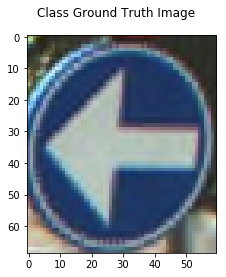

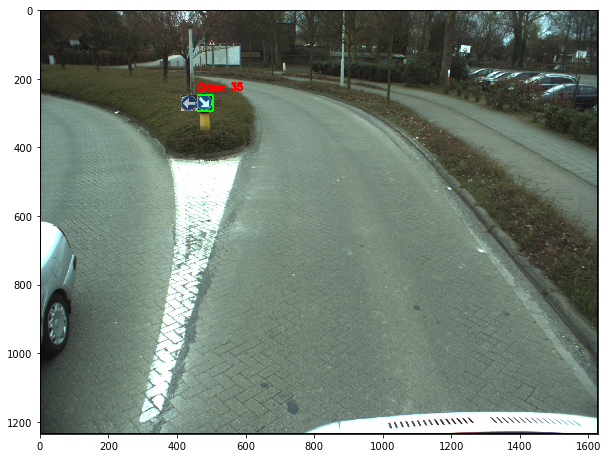

In [7]:

img = cv2.imread(image_path)
img_rgb=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_rgb[:,:,0] = cv2.medianBlur(img_rgb[:,:,0],3)
img_rgb[:,:,1] = cv2.medianBlur(img_rgb[:,:,1],3)
img_rgb[:,:,2] = cv2.medianBlur(img_rgb[:,:,2],3)

arr2=img_rgb.copy()
arr2 = cv2.normalize(arr2.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

imgr=arr2[:,:,0]
imgg=arr2[:,:,1]
imgb=arr2[:,:,2]

imgr=imadjust(imgr,imgr.min(),imgr.max(),0,1)
imgg=imadjust(imgg,imgg.min(),imgg.max(),0,1)
imgb=imadjust(imgb,imgb.min(),imgb.max(),0,1)

Cr = np.maximum(0,np.divide(np.minimum((imgr-imgb),(imgr-imgg)),(imgr+imgg+imgb)))
Cr[np.isnan(Cr)]=0

Cb = np.maximum(0,np.divide((imgb-imgr),(imgr+imgg+imgb)))
Cb[np.isnan(Cb)]=0

[rows,cols]=img[:,:,1].shape

sc=(cv2.normalize(Cr.astype('float'), None, 0, 255, cv2.NORM_MINMAX)).astype('int')
mser = cv2.MSER_create(_min_area=100,_max_area=10000)

regions, _ = mser.detectRegions(sc.astype('uint8'))
BMred=np.zeros((rows,cols))
if len(regions)>0:
    
    for i in range(len(regions)):
        for j in range(len(regions[i])):
            BMred[regions[i][j][1],regions[i][j][0]]=1
        
sb=(cv2.normalize(Cb.astype('float'), None, 0, 255, cv2.NORM_MINMAX)).astype('int')
mser = cv2.MSER_create(_min_area=100,_max_area=10000)

regions, _ = mser.detectRegions(sb.astype('uint8'))
BMblue=np.zeros((rows,cols))
if len(regions)>0:
    for i in range(len(regions)):
        for j in range(len(regions[i])):
            BMblue[regions[i][j][1],regions[i][j][0]]=1
        
        
img_hsv=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

s=cv2.normalize(img_hsv[:,:,1].astype('float'), None, 0, 1, cv2.NORM_MINMAX)
v=cv2.normalize(img_hsv[:,:,2].astype('float'), None, 0, 1, cv2.NORM_MINMAX)

# s[s<0.6]=0
# s[s>0.89]=0
# s[s>0]=1

# v[v<0.2]=0
# v[v>0.75]=0
# v[v>0]=1

s[s<0.5]=0
s[s>0.65]=0
s[s>0]=1

v[v<0.2]=0
v[v>0.75]=0
v[v>0]=1

redmask=np.multiply(s,v)


s=cv2.normalize(img_hsv[:,:,1].astype('float'), None, 0, 1, cv2.NORM_MINMAX)
v=cv2.normalize(img_hsv[:,:,2].astype('float'), None, 0, 1, cv2.NORM_MINMAX)

s[s<0.45]=0
s[s>0.80]=0
s[s>0]=1

v[v<0.35]=0
v[v>1]=0
v[v>0]=1

bluemask=np.multiply(s,v)


BMred_mask=np.multiply(BMred,redmask)
BMblue_mask=np.multiply(BMblue,bluemask)


BMred_fill=image_fill(BMred_mask)
BMblue_fill=image_fill(BMblue_mask)


cont_Saver=cnts_find(BMblue_fill,BMred_fill)
if len(cont_Saver)>0:
    cont_Saver=np.array(cont_Saver)

    cont_Saver=cont_Saver[cont_Saver[:,0].argsort()].astype(int)
    for conta in range(len(cont_Saver)):
        cont_area,x, y, w, h=cont_Saver[len(cont_Saver)-conta-1]

        #getting the boundry of rectangle around the contours.

        image_found=img[y:y+h,x:x+w]

        crop_image=image_found.copy()
        img0=cv2.cvtColor(image_found, cv2.COLOR_RGB2GRAY)
        img0 = cv2.medianBlur(img0,3)

        crop_image0=cv2.resize(img0, (64, 64))

        # Apply Hog from skimage library it takes image as crop image.Number of orientation bins that gradient
        # need to calculate.
        ret,crop_image0 = cv2.threshold(crop_image0,127,255,cv2.THRESH_BINARY)
        descriptor,imagehog  = hog(crop_image0, orientations=8,pixels_per_cell=(4,4),visualize=True)


        # descriptor,imagehog = hog(crop_image0, orientations=8, visualize=True)
        descriptor_pca=pca.transform(descriptor.reshape(1,-1))

        # class predition of image using SVM
        Predicted_Class=classifier.predict(descriptor_pca)[0]


        if Predicted_Class !=38:
            print ('Predicted Class: ',Predicted_Class)
            ground_truth_image=cv2.imread('classes_images/'+str(Predicted_Class)+'.png')

            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 4)#drawing a green rectange around it.
            #Putting text on the upward of bounding box
            cv2.putText(img, 'Class: '+str(Predicted_Class), (x, y - 15),cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 6)

            #loading the ground truth class respective to the predicted class
            # displaying the ground truth image
            fig = plt.figure()
            plt.imshow(cv2.cvtColor(ground_truth_image,cv2.COLOR_BGR2RGB), cmap=plt.cm.gray)
            fig.suptitle('Class Ground Truth Image')
            plt.show()
            #ground truth image resize and match according to the sign detected

            try:

                ground_truth_image_resized=cv2.resize(ground_truth_image, (w,h))
                #replaceing the sign image adjacent(left side) to detected sign
                img[y:y+ground_truth_image_resized.shape[0], x-w:x-w+ground_truth_image_resized.shape[1]] = ground_truth_image_resized
            #if sign detected on left boundry then there will be an error because n0 place for image to place then this program run place the image one right side. 
            except:
                #ground truth image resize and match according to the sign detected
                ground_truth_image_resized=cv2.resize(ground_truth_image, (w,h))
                #replaceing the sign image adjacent(right side) to detected sign
                img[y:y+ground_truth_image_resized.shape[0], x+w:x+w+ground_truth_image_resized.shape[1]] = ground_truth_image_resized

            plt.figure(figsize=[10,10])
            plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
            cv2.imwrite('Final_Ouput.png',img)


In [9]:
img = cv2.imread(image_path)
img_rgb=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_rgb[:,:,0] = cv2.medianBlur(img_rgb[:,:,0],3)
img_rgb[:,:,1] = cv2.medianBlur(img_rgb[:,:,1],3)
img_rgb[:,:,2] = cv2.medianBlur(img_rgb[:,:,2],3)

In [10]:
img_bgr=cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

In [ ]:
def imadjust(x,a,b,c,d,gamma=1):
    # Similar to imadjust in MATLAB.
    # Converts an image range from [a,b] to [c,d].
    # The Equation of a line can be used for this transformation:
        #   y=((d-c)/(b-a))*(x-a)+c
    # However, it is better to use a more generalized equation:
    #   y=((x-a)/(b-a))^gamma*(d-c)+c
    # If gamma is equal to 1, then the line equation is used.
    # When gamma is not equal to 1, then the transformation is not linear.

    y = (((x - a) / (b - a)) ** gamma) * (d - c) + c
    return y
def image_fill(Binary_image):
    # Mask used to flood filling.
    im_th=Binary_image.astype('uint8').copy()
    h, w = im_th.shape[:2]
    im_floodfill = im_th.copy()
    mask = np.zeros((h+2, w+2), np.uint8)

    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (0,0), 1);

    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground.
    im_out = im_th | im_floodfill_inv
    im_out[im_out==254]=0
    return im_out

def cnts_find(binary_image_blue,binary_image_red):
    cont_Saver=[]
    
    (_,cnts, _) = cv2.findContours(binary_image_blue.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)#finding contours of conected component
    for d in cnts:
         if cv2.contourArea(d)>700:
                (x, y, w, h) = cv2.boundingRect(d)
                if ((w/h)<1.21 and (w/h)>0.59 and w>20):
                    cont_Saver.append([cv2.contourArea(d),x, y, w, h])
    
    (_,cnts, _) = cv2.findContours(binary_image_red.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)#finding contours of conected component
    for d in cnts:
         if cv2.contourArea(d)>700:
                (x, y, w, h) = cv2.boundingRect(d)
                if ((w/h)<1.21 and (w/h)>0.59 and w>20):
                    cont_Saver.append([cv2.contourArea(d),x, y, w, h])
    return cont_Saver

In [42]:
cv2.imwrite('image_found.png',imagehog)

True

In [41]:
image_found=img[y:y+h,x:x+w]
cv2.imshow('image',imagehog)
cv2.waitKey(0)
cv2.destroyAllWindows()

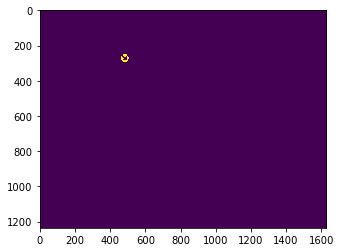

In [33]:
plt.imshow(BMblue_fill)

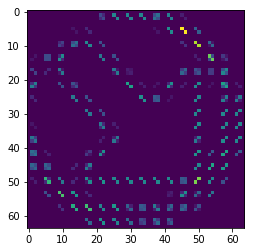

In [40]:
plt.imshow(imagehog)

In [37]:

img = cv2.imread(image_path)

Predicted Class:  35


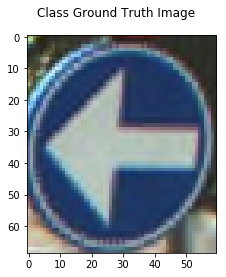

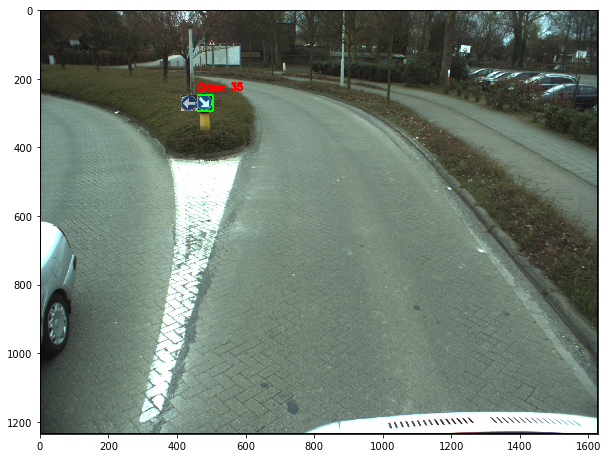

In [32]:

img = cv2.imread(image_path)
img_rgb=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_rgb[:,:,0] = cv2.medianBlur(img_rgb[:,:,0],3)
img_rgb[:,:,1] = cv2.medianBlur(img_rgb[:,:,1],3)
img_rgb[:,:,2] = cv2.medianBlur(img_rgb[:,:,2],3)

arr2=img_rgb.copy()
arr2 = cv2.normalize(arr2.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

imgr=arr2[:,:,0]
imgg=arr2[:,:,1]
imgb=arr2[:,:,2]

imgr=imadjust(imgr,imgr.min(),imgr.max(),0,1)
imgg=imadjust(imgg,imgg.min(),imgg.max(),0,1)
imgb=imadjust(imgb,imgb.min(),imgb.max(),0,1)

Cr = np.maximum(0,np.divide(np.minimum((imgr-imgb),(imgr-imgg)),(imgr+imgg+imgb)))
Cr[np.isnan(Cr)]=0

Cb = np.maximum(0,np.divide((imgb-imgr),(imgr+imgg+imgb)))
Cb[np.isnan(Cb)]=0

[rows,cols]=img[:,:,1].shape

sc=(cv2.normalize(Cr.astype('float'), None, 0, 255, cv2.NORM_MINMAX)).astype('int')
mser = cv2.MSER_create(_min_area=100,_max_area=10000)

regions, _ = mser.detectRegions(sc.astype('uint8'))
BMred=np.zeros((rows,cols))
if len(regions)>0:
    
    for i in range(len(regions)):
        for j in range(len(regions[i])):
            BMred[regions[i][j][1],regions[i][j][0]]=1
        
sb=(cv2.normalize(Cb.astype('float'), None, 0, 255, cv2.NORM_MINMAX)).astype('int')
mser = cv2.MSER_create(_min_area=100,_max_area=10000)

regions, _ = mser.detectRegions(sb.astype('uint8'))
BMblue=np.zeros((rows,cols))
if len(regions)>0:
    for i in range(len(regions)):
        for j in range(len(regions[i])):
            BMblue[regions[i][j][1],regions[i][j][0]]=1
        
        
img_hsv=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

s=cv2.normalize(img_hsv[:,:,1].astype('float'), None, 0, 1, cv2.NORM_MINMAX)
v=cv2.normalize(img_hsv[:,:,2].astype('float'), None, 0, 1, cv2.NORM_MINMAX)

# s[s<0.6]=0
# s[s>0.89]=0
# s[s>0]=1

# v[v<0.2]=0
# v[v>0.75]=0
# v[v>0]=1

s[s<0.5]=0
s[s>0.65]=0
s[s>0]=1

v[v<0.2]=0
v[v>0.75]=0
v[v>0]=1

redmask=np.multiply(s,v)


s=cv2.normalize(img_hsv[:,:,1].astype('float'), None, 0, 1, cv2.NORM_MINMAX)
v=cv2.normalize(img_hsv[:,:,2].astype('float'), None, 0, 1, cv2.NORM_MINMAX)

s[s<0.45]=0
s[s>0.80]=0
s[s>0]=1

v[v<0.35]=0
v[v>1]=0
v[v>0]=1

bluemask=np.multiply(s,v)


BMred_mask=np.multiply(BMred,redmask)
BMblue_mask=np.multiply(BMblue,bluemask)


BMred_fill=image_fill(BMred_mask)
BMblue_fill=image_fill(BMblue_mask)


cont_Saver=cnts_find(BMblue_fill,BMred_fill)
if len(cont_Saver)>0:
    cont_Saver=np.array(cont_Saver)

    cont_Saver=cont_Saver[cont_Saver[:,0].argsort()].astype(int)
    for conta in range(len(cont_Saver)):
        cont_area,x, y, w, h=cont_Saver[len(cont_Saver)-conta-1]

        #getting the boundry of rectangle around the contours.

        image_found=img[y:y+h,x:x+w]

        crop_image=image_found.copy()
        img0=cv2.cvtColor(image_found, cv2.COLOR_RGB2GRAY)
        img0 = cv2.medianBlur(img0,3)

        crop_image0=cv2.resize(img0, (64, 64))

        # Apply Hog from skimage library it takes image as crop image.Number of orientation bins that gradient
        # need to calculate.
        ret,crop_image0 = cv2.threshold(crop_image0,127,255,cv2.THRESH_BINARY)
        descriptor,imagehog  = hog(crop_image0, orientations=8,pixels_per_cell=(4,4),visualize=True)


        # descriptor,imagehog = hog(crop_image0, orientations=8, visualize=True)
        descriptor_pca=pca.transform(descriptor.reshape(1,-1))

        # class predition of image using SVM
        Predicted_Class=classifier.predict(descriptor_pca)[0]


        if Predicted_Class !=38:
            print ('Predicted Class: ',Predicted_Class)
            ground_truth_image=cv2.imread('classes_images/'+str(Predicted_Class)+'.png')

            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 4)#drawing a green rectange around it.
            #Putting text on the upward of bounding box
            cv2.putText(img, 'Class: '+str(Predicted_Class), (x, y - 15),cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 6)

            #loading the ground truth class respective to the predicted class
            # displaying the ground truth image
            fig = plt.figure()
            plt.imshow(cv2.cvtColor(ground_truth_image,cv2.COLOR_BGR2RGB), cmap=plt.cm.gray)
            fig.suptitle('Class Ground Truth Image')
            plt.show()
            #ground truth image resize and match according to the sign detected

            try:

                ground_truth_image_resized=cv2.resize(ground_truth_image, (w,h))
                #replaceing the sign image adjacent(left side) to detected sign
                img[y:y+ground_truth_image_resized.shape[0], x-w:x-w+ground_truth_image_resized.shape[1]] = ground_truth_image_resized
            #if sign detected on left boundry then there will be an error because n0 place for image to place then this program run place the image one right side. 
            except:
                #ground truth image resize and match according to the sign detected
                ground_truth_image_resized=cv2.resize(ground_truth_image, (w,h))
                #replaceing the sign image adjacent(right side) to detected sign
                img[y:y+ground_truth_image_resized.shape[0], x+w:x+w+ground_truth_image_resized.shape[1]] = ground_truth_image_resized

            plt.figure(figsize=[10,10])
            plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
            cv2.imwrite('Final_Ouput.png',img)


### Visualize the Color thresholding and Morphology Operation:

Lets visualize those images that are generated by previous function to see that what step of image what happened to image.
We are visulizing four images:
1. Orignal Image
2. Threshold Image(When Red color range Detected)
3. Morphology(Opening) Operation
4. Morphology(Dilation) Operation

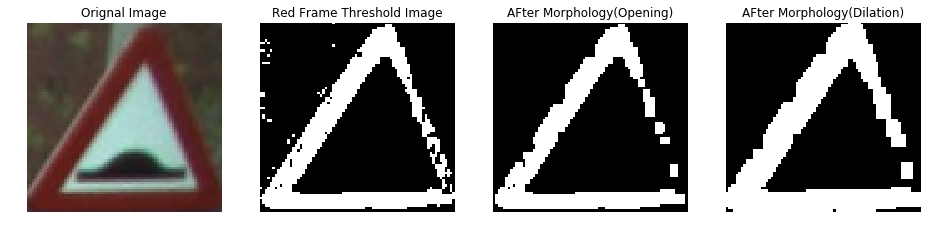

In [168]:
img = cv2.imread(image_path)
fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(16, 10), sharex=True, sharey=True)

#ploting crop image
ax1.axis('off')
ax1.imshow(cv2.cvtColor(img[y0-30:y0+h0+30,x0-30:x0+w0+30][y:y+h,x:x+w],cv2.COLOR_BGR2RGB), cmap=plt.cm.gray)
ax1.set_title('Orignal Image')


#ploting Hog image
ax2.axis('off')
ax2.imshow(frame_threshed_red[y0-30:y0+h0+30,x0-30:x0+w0+30][y:y+h,x:x+w], cmap=plt.cm.gray)
ax2.set_title('Red Frame Threshold Image')


#ploting Orignal image
ax3.axis('off')
ax3.imshow(thresh_red[y0-30:y0+h0+30,x0-30:x0+w0+30][y:y+h,x:x+w], cmap=plt.cm.gray)
ax3.set_title('AFter Morphology(Opening)')


#ploting Orignal image
ax4.axis('off')
ax4.imshow(dilation_red[y0-30:y0+h0+30,x0-30:x0+w0+30][y:y+h,x:x+w], cmap=plt.cm.gray)
ax4.set_title('AFter Morphology(Dilation)')
plt.show()


### Testing on Folder of Images and save it as video:

This code processing method is the same as for one image, we have seen upword. the only difference here is saving the output on the video.

Reading Image from  dataset/input


In [488]:
Folder_path='dataset/input'
print('Reading Image from ',Folder_path)

images_paths=glob.glob(Folder_path+'/*.jpg')# Reading all the images path 
img1 = cv2.imread(images_paths[0])# reading the first image to check the size shape of image so that we make a video same of image size
height , width , layers =  img1.shape
#video intialization with 30 frame persec, hight and width is equal to first image hight and width
video = cv2.VideoWriter('video.avi',cv2.VideoWriter_fourcc(*'MPEG'),30,(width,height))

for frame in range(len(images_paths)):
    img = cv2.imread(images_paths[frame])# reading the ith image
    

    img_rgb=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_rgb[:,:,0] = cv2.medianBlur(img_rgb[:,:,0],3)
    img_rgb[:,:,1] = cv2.medianBlur(img_rgb[:,:,1],3)
    img_rgb[:,:,2] = cv2.medianBlur(img_rgb[:,:,2],3)

    arr2=img_rgb.copy()
    arr2 = cv2.normalize(arr2.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

    imgr=arr2[:,:,0]
    imgg=arr2[:,:,1]
    imgb=arr2[:,:,2]

    imgr=imadjust(imgr,imgr.min(),imgr.max(),0,1)
    imgg=imadjust(imgg,imgg.min(),imgg.max(),0,1)
    imgb=imadjust(imgb,imgb.min(),imgb.max(),0,1)

    Cr = np.maximum(0,np.divide(np.minimum((imgr-imgb),(imgr-imgg)),(imgr+imgg+imgb)))
    Cr[np.isnan(Cr)]=0

    Cb = np.maximum(0,np.divide((imgb-imgr),(imgr+imgg+imgb)))
    Cb[np.isnan(Cb)]=0

    [rows,cols]=img[:,:,1].shape

    sc=(cv2.normalize(Cr.astype('float'), None, 0, 255, cv2.NORM_MINMAX)).astype('int')
    mser = cv2.MSER_create(_min_area=100,_max_area=10000)

    regions, _ = mser.detectRegions(sc.astype('uint8'))
    if len(regions)>0:
        BMred=np.zeros((rows,cols))
        for i in range(len(regions)):
            for j in range(len(regions[i])):
                BMred[regions[i][j][1],regions[i][j][0]]=1

    sb=(cv2.normalize(Cb.astype('float'), None, 0, 255, cv2.NORM_MINMAX)).astype('int')
    mser = cv2.MSER_create(_min_area=100,_max_area=10000)

    regions, _ = mser.detectRegions(sb.astype('uint8'))
    if len(regions)>0:
        BMblue=np.zeros((rows,cols))
        for i in range(len(regions)):
            for j in range(len(regions[i])):
                BMblue[regions[i][j][1],regions[i][j][0]]=1


    img_hsv=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    s=cv2.normalize(img_hsv[:,:,1].astype('float'), None, 0, 1, cv2.NORM_MINMAX)
    v=cv2.normalize(img_hsv[:,:,2].astype('float'), None, 0, 1, cv2.NORM_MINMAX)

    # s[s<0.6]=0
    # s[s>0.89]=0
    # s[s>0]=1

    # v[v<0.2]=0
    # v[v>0.75]=0
    # v[v>0]=1

    s[s<0.5]=0
    s[s>0.65]=0
    s[s>0]=1

    v[v<0.2]=0
    v[v>0.75]=0
    v[v>0]=1

    redmask=np.multiply(s,v)


    s=cv2.normalize(img_hsv[:,:,1].astype('float'), None, 0, 1, cv2.NORM_MINMAX)
    v=cv2.normalize(img_hsv[:,:,2].astype('float'), None, 0, 1, cv2.NORM_MINMAX)

    s[s<0.45]=0
    s[s>0.80]=0
    s[s>0]=1

    v[v<0.35]=0
    v[v>1]=0
    v[v>0]=1

    bluemask=np.multiply(s,v)


    BMred_mask=np.multiply(BMred,redmask)
    BMblue_mask=np.multiply(BMblue,bluemask)


    BMred_fill=image_fill(BMred_mask)
    BMblue_fill=image_fill(BMblue_mask)


    cont_Saver=cnts_find(BMblue_fill,BMred_fill)
    if len(cont_Saver)>0:
        cont_Saver=np.array(cont_Saver)

        cont_Saver=cont_Saver[cont_Saver[:,0].argsort()].astype(int)
        if len(cont_Saver)>5:
            numberof_cont=5
        else:
            numberof_cont=len(cont_Saver)
        for conta in range(numberof_cont):
            cont_area,x, y, w, h=cont_Saver[len(cont_Saver)-conta-1]

            #getting the boundry of rectangle around the contours.

            image_found=img[y:y+h,x:x+w]

            crop_image=image_found.copy()
            img0=cv2.cvtColor(image_found, cv2.COLOR_RGB2GRAY)
            img0 = cv2.medianBlur(img0,3)

            crop_image0=cv2.resize(img0, (64, 64))

            # Apply Hog from skimage library it takes image as crop image.Number of orientation bins that gradient
            # need to calculate.
            ret,crop_image0 = cv2.threshold(crop_image0,127,255,cv2.THRESH_BINARY)
            descriptor,imagehog  = hog(crop_image0, orientations=8,pixels_per_cell=(4,4),visualize=True)


            # descriptor,imagehog = hog(crop_image0, orientations=8, visualize=True)
            descriptor_pca=pca.transform(descriptor.reshape(1,-1))

            # class predition of image using SVM
            Predicted_Class=classifier.predict(descriptor_pca)[0]


            if Predicted_Class !=38:
                if Predicted_Class!=19:
                
                    print ('Predicted Class: ',Predicted_Class,cont_area)
                    ground_truth_image=cv2.imread('classes_images/'+str(Predicted_Class)+'.png')

                    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 4)#drawing a green rectange around it.
                    #Putting text on the upward of bounding box
                    cv2.putText(img, 'Class: '+str(Predicted_Class), (x, y - 15),cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 6)

                    #loading the ground truth class respective to the predicted class
                    # displaying the ground truth image

                    #ground truth image resize and match according to the sign detected

                    try:

                        ground_truth_image_resized=cv2.resize(ground_truth_image, (w,h))
                        #replaceing the sign image adjacent(left side) to detected sign
                        img[y:y+ground_truth_image_resized.shape[0], x-w:x-w+ground_truth_image_resized.shape[1]] = ground_truth_image_resized
                    #if sign detected on left boundry then there will be an error because n0 place for image to place then this program run place the image one right side. 
                    except:
                        #ground truth image resize and match according to the sign detected
                        ground_truth_image_resized=cv2.resize(ground_truth_image, (w,h))
                        #replaceing the sign image adjacent(right side) to detected sign
                        img[y:y+ground_truth_image_resized.shape[0], x+w:x+w+ground_truth_image_resized.shape[1]] = ground_truth_image_resized

            
    
#     cv2.imwrite('result.png',img)
    video.write(img) #frame embeding on the video.
    if frame%10==0:
        print ('FRAME READ: ',frame)
#clearing cv2
cv2.destroyAllWindows()
video.release()

FRAME READ:  0
FRAME READ:  10
FRAME READ:  20
FRAME READ:  30
FRAME READ:  40
FRAME READ:  50
FRAME READ:  60
FRAME READ:  70
Predicted Class:  45 1591
FRAME READ:  80
Predicted Class:  45 1758
Predicted Class:  45 1838
Predicted Class:  45 1946
Predicted Class:  45 2076
Predicted Class:  45 2182
Predicted Class:  45 2337
Predicted Class:  45 2485
Predicted Class:  45 2725
Predicted Class:  45 2887
Predicted Class:  45 3098
FRAME READ:  90
Predicted Class:  45 3356
Predicted Class:  45 3670
Predicted Class:  45 4000
Predicted Class:  45 4331
Predicted Class:  45 4759
Predicted Class:  45 5278
Predicted Class:  45 5852
Predicted Class:  45 6547
Predicted Class:  45 7433
Predicted Class:  45 8420
FRAME READ:  100
Predicted Class:  45 9707
Predicted Class:  45 11341
Predicted Class:  45 12293
FRAME READ:  110
FRAME READ:  120
FRAME READ:  130
FRAME READ:  140
FRAME READ:  150
FRAME READ:  160
FRAME READ:  170
Predicted Class:  45 774
Predicted Class:  45 798
FRAME READ:  180
Predicted Cl

Predicted Class:  35 788
Predicted Class:  35 830
Predicted Class:  35 863
Predicted Class:  35 893
FRAME READ:  1480
Predicted Class:  35 1588
Predicted Class:  35 1051
Predicted Class:  35 1947
Predicted Class:  35 1263
FRAME READ:  1490
Predicted Class:  35 2180
Predicted Class:  35 1495
Predicted Class:  35 2401
Predicted Class:  35 2480
Predicted Class:  35 2642
Predicted Class:  35 2743
FRAME READ:  1500
Predicted Class:  35 2847
Predicted Class:  35 2960
Predicted Class:  35 3187
Predicted Class:  35 3324
Predicted Class:  35 3464
Predicted Class:  35 3604
Predicted Class:  35 3761
Predicted Class:  35 3910
Predicted Class:  35 4085
FRAME READ:  1510
Predicted Class:  35 4281
Predicted Class:  35 4492
Predicted Class:  35 4727
Predicted Class:  35 4969
Predicted Class:  35 5273
Predicted Class:  35 5575
Predicted Class:  35 5963
Predicted Class:  35 6383
Predicted Class:  1 3774
FRAME READ:  1520
FRAME READ:  1530
FRAME READ:  1540
FRAME READ:  1550
FRAME READ:  1560
FRAME READ:

In [487]:
video.release()

### Drawbacks:

The system is not Robust as It detecting the same color other objects also as steet sign. Even we tried to use different threshold of width, hight and contours area but still some object detected other than street Signs.

The Future approach possible by using deep learning methods for object detection like yolo, faster RCNN.